### Phugoid Model

The system equation:
$$
\begin{align}
    v' & = - g\sin\theta - \frac{C_D}{C_L} \frac{g}{v_t^2} v^2 \\
    \theta' & = - \frac{g}{v}\cos\theta + \frac{g}{v_t^2}v
\end{align}
$$

Converting the velocity into inertial coordinate frame ($x$, $y$),
$$
\begin{align}
     x'(t) & = v \cos(\theta) \\
     y'(t) & = v \sin(\theta)
\end{align}
$$

### Descritization

$$
\begin{align}
    v^{n+1} & = v^n + \Delta t \, \left(- g\sin\theta^n - \frac{C_D}{C_L} \frac{g}{v_t^2} (v^n)^2 \right) \\
    \theta^{n+1} & = \theta^n + \Delta t \, \left(- \frac{g}{v^n}\cos\theta^n + \frac{g}{v_t^2} v^n \right) \\
    x^{n+1} & = x^n + \Delta t \, v^n \cos\theta^n \\
    y^{n+1} & = y^n + \Delta t \, v^n \sin\theta^n
\end{align}
$$

Re-arranging above equation into the form $u'(t) = f(u)$,

$$
\begin{align}
    u & = 
    \begin{pmatrix} 
    v \\ \theta \\ x \\ y 
    \end{pmatrix}
    &
    f(u) & = 
    \begin{pmatrix} 
    - g \sin\theta - \frac{C_D}{C_L} \frac{g}{v_t^2} v^2 \\ 
    - \frac{g}{v}\cos\theta + \frac{g}{v_t^2} v \\
    v\,\cos\theta \\
    v\,\sin\theta 
    \end{pmatrix}
\end{align}
$$

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# set the font family and size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [3]:
# parameters
g = 9.81
vt = 30.0  # trim velocity
CD = 1.0 / 40.0
CL = 1.0

# initial conditions
v0 = vt
th0 = 0.0  # trajectory angle
x0 = 0.0  # horizontal position
y0 = 1000.0  # altitude

In [4]:
def rhs_phugoid(u, CL, CD, g, vt):
    '''
    Returns the right hand side of the EOM of phugoid mode
    
    Parameters
    ----------
    u: list or np.ndarray
        Solution at the previous time step as a list of 1D array of four floats
    CL: float
        Lift coefficient
    CD: float
        Drag coefficient
    g: float
        Gravitational acceleration
    vt: float
        Trim velocity
        
    Returns
    -------
    rhs: np.ndarray
        RHS of the EOM as a 1D aray of fout floats
    '''
    
    v, th, x, y = u
    
    rhs = np.array([
        -g * math.sin(th) - CD / CL * g / vt**2 * v**2,
        -g / v * math.cos(th) + g / vt**2 * v,
        v * math.cos(th),
        v * math.sin(th)
    ])
    
    return rhs

In [5]:
def euler_step(u, f, dt, *args):
    '''
    Returns the solution at the next step using Euler's method
    
    Parameters
    ----------
    u: np.ndarray
        Solution at the previous step as a 1D array of four floats
    f: function
        Function to compute the RHS of the system
    dt: float
        Step size
    args: optional arguments
        Positional arguments to pass to the function f
        
    Returns
    -------
    
    u_new: np.ndarray
        Solution at the next time step as a 1D array of floats
    '''
    
    u_new = u + dt * f(u, *args)
    
    return u_new 

In [7]:
T = 100.0  # time length
dt = 0.1  # step size
N = int(T / dt) + 1

# array to save the output
u = np.empty((N, 4))
u[0] = np.array([v0, th0, x0, y0])

# time integration with Euler's method
for n in range(N - 1):
    u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)

In [9]:
x = u[:, 2]
y = u[:, 3]

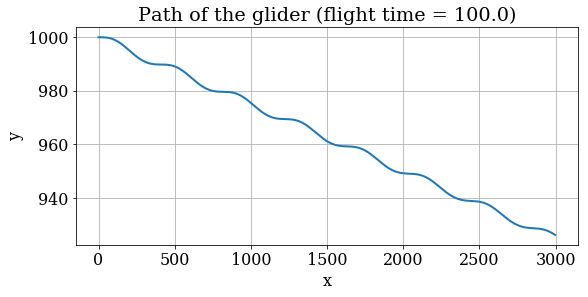

In [10]:
# plot the glider path
plt.figure(figsize=(9.0, 4.0))
plt.title('Path of the glider (flight time = {})'.format(T))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.plot(x, y, color='C0', linestyle='-', linewidth=2);

### Grid Convergence

In [11]:
# list of different time step sizes
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

# empty list to save solution for each grid
u_values = []

for dt in dt_values:
    N = int(T /dt) + 1
    u = np.empty((N, 4))
    u[0] = np.array([v0, th0, x0, y0])
    
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    
    u_values.append(u)

In [12]:
def l1_diff(u_coarse, u_fine, dt):
    '''
    Returns the difference in the L1-norm between the solution on a coarse
    grid and the solution on a fine grid
    
    Parameters
    ----------
    u_coarse: np.ndarray
        Solution on the coarse grid as an array of floats
    u_fine: np.ndarray
        Solution on the fine grid as an array of floats
    dt: float
        Step size
        
    Returns
    -------
    diff: float
        The difference between the two solutions in the L1-norm, scaled by dt
    '''
    
    N_coarse = len(u_coarse)
    N_fine = len(u_fine)
    ratio = math.ceil(N_fine / N_coarse)
    
    diff = dt * np.sum(np.abs(u_coarse - u_fine[::ratio]))
    
    return diff

In [13]:
diff_values = []

for i, dt in enumerate(dt_values[:-1]):
    diff = l1_diff(u_values[i][:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

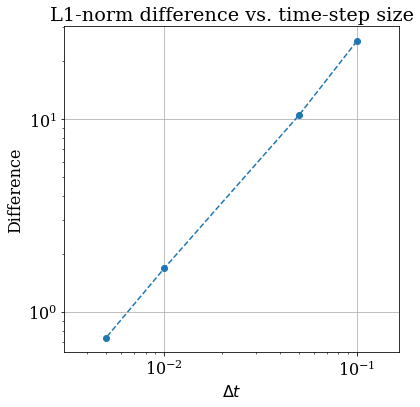

In [14]:
plt.figure(figsize=(6.0, 6.0))
plt.title('L1-norm difference vs. time-step size')
plt.xlabel('$\Delta t$')
plt.ylabel('Difference')
plt.grid()
plt.loglog(dt_values[:-1], diff_values,
              color='C0', linestyle='--', marker='o')
plt.axis('equal');

In [ ]:
r = 2  # refinement ratio for the time-step size
h = 0.001  # base grid size

dt_values2 = [h, r * h, r**2 * h]
u_values2 = []

for dt in dt_values2:
    N = int(T / dt) + 1
    u = np.empty((N, 4))
    
    u[0] = np.array([v0, th0, x0, y0])
    
    # integration using Euler's method.
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    
    u_values2.append(u)

# calculate f2 - f1.
f2_f1 = l1_diff(u_values2[1][:, 2], u_values2[0][:, 2], dt_values2[1])
# Calculate f3 - f2.
f3_f2 = l1_diff(u_values2[2][:, 2], u_values2[1][:, 2], dt_values2[2])
# Calculate the observed order of convergence.
p = math.log(f3_f2 / f2_f1) / math.log(r)
print('Observed order of convergence: p = {:.3f}'.format(p))